In [100]:
import math
import os
import pickle
import random
import sys
import time
from contextlib import suppress
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
crime_test = pd.read_csv("test.csv", sep=',',error_bad_lines=False)
crime_train = pd.read_csv("train.csv", sep=',',error_bad_lines=False)

In [3]:
def transformX(dataset):
  dataset.loc[:, 'DayOfWeek'] = np.array([time.strptime(dow, '%A').tm_wday for dow in dataset.loc[:, 'DayOfWeek']], dtype=np.float)
  dataset.loc[:, 'Address'] = np.array([1 if 'block' in row else 0 for row in dataset.loc[:, 'Address']], dtype=np.float)
  # Districts
  districts = sorted(dataset.PdDistrict.unique())
  for d in districts:
    dataset.loc[:, d] = np.array([1 if d == x else 0 for x in dataset.loc[:, 'PdDistrict']], dtype=np.float)
  # Date
  datefmt = '%Y-%m-%d %H:%M:%S'
  def transform_time(tm):
    if tm.hour >= 0 and tm.hour <= 6:
      return 0
    elif tm.hour >= 6 and tm.hour <= 12:
      return 1
    elif tm.hour >= 12 and tm.hour <= 18:
      return 2
    return 3
  dataset.loc[:, 'Year'] = np.array([datetime.strptime(row, datefmt).year for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Month'] = np.array([datetime.strptime(row, datefmt).month for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Day'] = np.array([datetime.strptime(row, datefmt).day for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Hour'] = np.array([datetime.strptime(row, datefmt).time().hour for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Minute'] = np.array([datetime.strptime(row, datefmt).time().minute for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Period'] = np.array([transform_time(datetime.strptime(row, datefmt).time()) for row in dataset.loc[:, 'Dates']], dtype=np.float)
  return dataset.drop(columns=['PdDistrict', 'Dates'])

In [4]:
# raw_train = pd.read_csv(crime_train)
X_train = crime_train[['X', 'Y', 'DayOfWeek', 'Address', 'PdDistrict', 'Dates']]
Y_train = crime_train['Category']
# del raw_train

X_train = transformX(X_train)
Y_labels = sorted(Y_train.unique())
Y_train = np.array([Y_labels.index(cat) for cat in Y_train], dtype=np.float)

# raw_test = pd.read_csv(crime_test)
X_test = crime_test[['X', 'Y', 'DayOfWeek', 'Address', 'PdDistrict', 'Dates']]
# del raw_test

X_test = transformX(X_test)

C:\Users\Abhishek\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Abhishek\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [5]:
scaler = StandardScaler()
pca = PCA()
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

xy = X_train[['X', 'Y']].to_numpy()
X_train.drop(columns=['X', 'Y'], inplace=True)
scaler.fit(xy)
xy = scaler.transform(xy)
pca.fit(xy)
xy_train = pca.transform(xy)

xy_test = pca.transform(scaler.transform(X_test[['X', 'Y']].to_numpy()))
X_test.drop(columns=['X', 'Y'], inplace=True)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.append(X_train, xy_train, axis=1)
X_test = np.append(X_test, xy_test, axis=1)

train_idx, val_idx = next(ss_split.split(X_train, Y_train))
X_val, Y_val = X_train[val_idx], Y_train[val_idx]
X_train, Y_train = X_train[train_idx], Y_train[train_idx]

#Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=len(Y_labels))
#Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=len(Y_labels))

In [58]:
def xgb_train(params):
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_val, label=Y_val)
    eval_set  = [(X_train, Y_train), (X_val, Y_val)]
    
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    
    classifier = xgb.XGBClassifier(
        max_depth=  params['max_depth'],
        min_child_weight= params['min_child_weight'],
        subsample= params['subsample'],
        gamma= params['gamma'],
        n_estimators= 20,
        colsample_bytree= params['colsample_bytree'],
        eta= params['eta'],
        eval_metric= 'mlogloss',
        objective= 'multi:softprob',
        nthread= 4,
        seed= 101,
        num_class= 39
    )
    
    model = classifier.fit(
        X_train,
        Y_train,
        eval_set=eval_set,
        eval_metric='mlogloss',
        early_stopping_rounds=10
    )
    
    predictions = model.predict_proba(X_val, ntree_limit=model.best_iteration+1)
    loss = log_loss(Y_val, predictions)
    
    return {'loss':loss, 'status': STATUS_OK}

In [59]:
def optimizer(trials):
    space = {
        'max_depth':  hp.choice('max_depth', np.arange(3,10,dtype=int)),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.5, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'n_estimators': 20,
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'nthread': 4,
        'seed': 101,
        'num_class': 39
    }
    
    best_params = fmin(
        fn=xgb_train, 
        space=space, 
        algo=tpe.suggest, 
        max_evals=10, 
        trials=trials
    )
    
    return best_params

In [60]:
trials = Trials()
best = optimizer(trials)
print (best)

[0]	validation_0-mlogloss:3.47465	validation_1-mlogloss:3.47652                                                        

Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.                       


Will train until validation_1-mlogloss hasn't improved in 10 rounds.                                                   

[1]	validation_0-mlogloss:3.33125	validation_1-mlogloss:3.33441                                                        

[2]	validation_0-mlogloss:3.21853	validation_1-mlogloss:3.2229                                                         

[3]	validation_0-mlogloss:3.12979	validation_1-mlogloss:3.13519                                                        

[4]	validation_0-mlogloss:3.05411	validation_1-mlogloss:3.06066                                                        

[5]	validation_0-mlogloss:2.98764	validation_1-mlogloss:2.99513                                                        

[6]	validation_0-mlogloss:2.932

Will train until validation_1-mlogloss hasn't improved in 10 rounds.                                                   

[1]	validation_0-mlogloss:3.33321	validation_1-mlogloss:3.33629                                                        

[2]	validation_0-mlogloss:3.22086	validation_1-mlogloss:3.22502                                                        

[3]	validation_0-mlogloss:3.13193	validation_1-mlogloss:3.13716                                                        

[4]	validation_0-mlogloss:3.05624	validation_1-mlogloss:3.06248                                                        

[5]	validation_0-mlogloss:2.98928	validation_1-mlogloss:2.99642                                                        

[6]	validation_0-mlogloss:2.93445	validation_1-mlogloss:2.94251                                                        

[7]	validation_0-mlogloss:2.88658	validation_1-mlogloss:2.89552                                                        

[8]	validation_0-mlogloss:2.8415

In [61]:
print (best)

{'colsample_bytree': 0.6000000000000001, 'eta': 0.1, 'gamma': 0.6000000000000001, 'max_depth': 6, 'x_min_child': 2.0, 'x_subsample': 0.5955171559578585}


In [72]:
#params = {
#    'colsample_bytree': 0.6000000000000001, 
#    'eta': 0.1, 
#    'gamma': 0.6000000000000001, 
#    'max_depth': 6, 
#    'x_min_child': 2.0, 
#    'x_subsample': 0.5955171559578585
#}
params = best

In [73]:
classifier = xgb.XGBClassifier(
        max_depth=  params['max_depth'],
        min_child_weight= params['x_min_child'],
        subsample= params['x_subsample'],
        gamma= params['gamma'],
        n_estimators= 100,
        colsample_bytree= params['colsample_bytree'],
        eta= params['eta'],
        eval_metric= 'mlogloss',
        objective= 'multi:softprob',
        nthread= 4,
        seed= 101,
        num_class= 39
    )

In [68]:
eval_set  = [(X_train, Y_train), (X_val, Y_val)]

model = classifier.fit(
        X_train,
        Y_train,
        eval_set=eval_set,
        eval_metric='mlogloss',
        early_stopping_rounds=10
    )

[0]	validation_0-mlogloss:3.48111	validation_1-mlogloss:3.48208
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:3.34084	validation_1-mlogloss:3.34277
[2]	validation_0-mlogloss:3.2314	validation_1-mlogloss:3.23404
[3]	validation_0-mlogloss:3.14466	validation_1-mlogloss:3.14792
[4]	validation_0-mlogloss:3.07061	validation_1-mlogloss:3.07448
[5]	validation_0-mlogloss:3.00456	validation_1-mlogloss:3.00891
[6]	validation_0-mlogloss:2.95075	validation_1-mlogloss:2.95564
[7]	validation_0-mlogloss:2.90321	validation_1-mlogloss:2.90858
[8]	validation_0-mlogloss:2.85872	validation_1-mlogloss:2.86451
[9]	validation_0-mlogloss:2.82099	validation_1-mlogloss:2.82729
[10]	validation_0-mlogloss:2.78458	validation_1-mlogloss:2.79132
[11]	validation_0-mlogloss:2.75191	validation_1-mlogloss:2.7591
[12]	validation_0-mlogloss:2.7238	validation_1-mlogloss:2.73149
[

In [70]:
preds = model.predict_proba(X_test, ntree_limit=model.best_iteration+1)
predictions = pd.DataFrame(preds, columns=Y_labels)
predictions.index.name = 'Id'
predictions.to_csv('xgboost_preds.csv')
print(predictions)

           ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
Id                                                           
0       0.003659  0.076970    0.000249  0.001600  0.026575   
1       0.008160  0.111768    0.000213  0.001163  0.016109   
2       0.003163  0.108904    0.000274  0.000352  0.033178   
3       0.003377  0.130252    0.000233  0.001684  0.024017   
4       0.003377  0.130252    0.000233  0.001684  0.024017   
...          ...       ...         ...       ...       ...   
884257  0.000926  0.077855    0.007735  0.000424  0.023343   
884258  0.001223  0.069340    0.005953  0.000290  0.035452   
884259  0.002513  0.055239    0.007260  0.000385  0.023521   
884260  0.006678  0.091676    0.005430  0.000822  0.023064   
884261  0.002470  0.063299    0.004778  0.000311  0.030020   

        DISORDERLY CONDUCT  DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  \
Id                                                                       
0                 0.002607                   

In [71]:
print (accuracy_score(Y_val, model.predict(X_val))*100)
print (log_loss(Y_val, model.predict_proba(X_val, ntree_limit=model.best_iteration+1)))

29.79044473549342
2.338742765463262


In [ ]:
# roc multiclass
# y = label_binarize(Y_train, classes = list(range(39)))
lb = LabelBinarizer()
lb.fit(Y_val)
y_test = lb.transform(Y_val)
y_pred = model.predict_proba(X_val, ntree_limit=model.best_iteration+1)

In [88]:
print (roc_auc_score(y_test, y_pred, average='macro'))

0.7422633470666202


In [91]:
n_classes = len(Y_labels)
y_test = tf.keras.utils.to_categorical(Y_val, num_classes=len(Y_labels))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [92]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [95]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

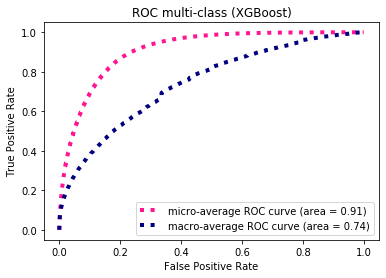

In [99]:
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class (XGBoost)')
plt.legend(loc="lower right")
plt.show()

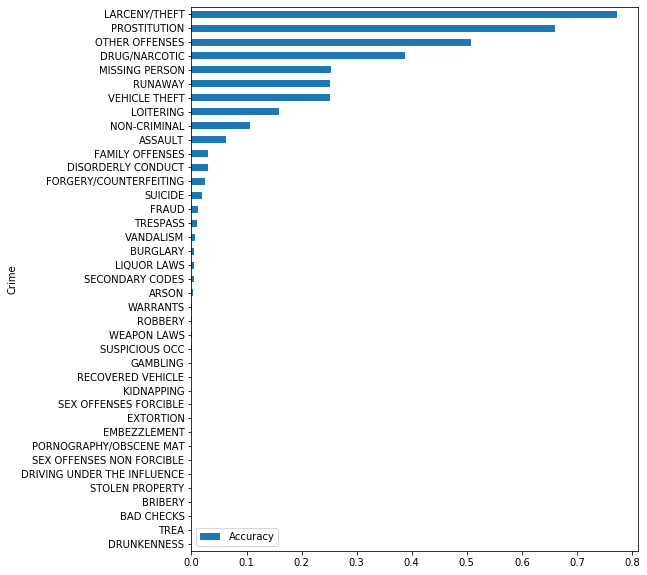

In [106]:
Y_val_pred = model.predict(X_val, ntree_limit=model.best_iteration+1)
cm = confusion_matrix(Y_val, Y_val_pred)
class_accuracies = cm.diagonal()/cm.sum(axis=1)
#print (class_accuracies)
#print(classification_report(y_val_true, Y_val_pred, target_names=Y_labels))

class_ac = pd.DataFrame(data=[Y_labels, class_accuracies], index=['Crime', 'Accuracy']).T
class_ac = class_ac.sort_values(by='Accuracy')
class_ac.plot(x='Crime', y='Accuracy', kind='barh', figsize=(8,10))
#labels, counts = np.unique(raw_train['Category'], return_counts=True)
# y_pos = np.arange(len(Y_labels))
# plt.figure(figsize=(10,5))
# plt.bar(y_pos, class_accuracies, align='edge', width=0.8)
# plt.xticks(y_pos, Y_labels, rotation='vertical')
# plt.ylabel('Accuracy')
# plt.title('Class accuracy')
# plt.subplots_adjust(bottom=0.15)
# plt.show()

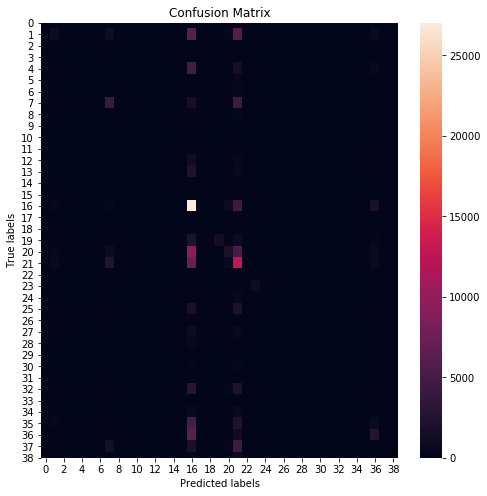

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');